In [1]:
import os
from obspy import read,Stream
import matplotlib.pyplot as plt
from utils.basic_utils import read_sac_ref_time,spherical_dist
import numpy as np

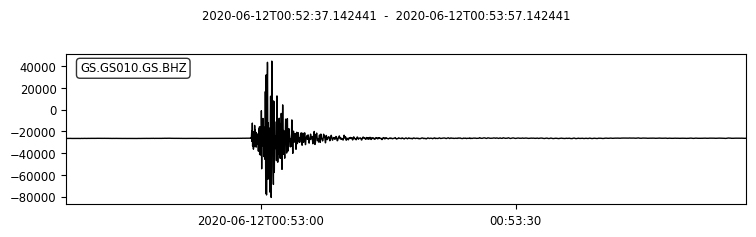

21 Trace(s) in Stream:

GS.GS010.GS.BHZ | 2020-06-12T00:52:57.142441Z - 2020-06-12T00:53:07.142441Z | 100.0 Hz, 1001 samples
...
(19 other traces)
...
ML.ML77.ML.BHZ | 2020-06-12T00:52:57.146094Z - 2020-06-12T00:53:07.146094Z | 100.0 Hz, 1001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [2]:
st = read("wf/*34362*Z")
st[0].plot()
try:
    e_mag = st[0].stats.sac.mag
except:
    e_mag = -9
starttime=st[0].stats.starttime
endtime =st[0].stats.endtime
sac_ref_time = read_sac_ref_time(st[0]) #In UTCDateTime format
o_value = st[0].stats.sac.o 
event_time = sac_ref_time + o_value #event origin time
st.trim(starttime = event_time, endtime = event_time + 10)
st.detrend("linear")
st.detrend("constant")
st.filter("bandpass",freqmin=5,freqmax=14)


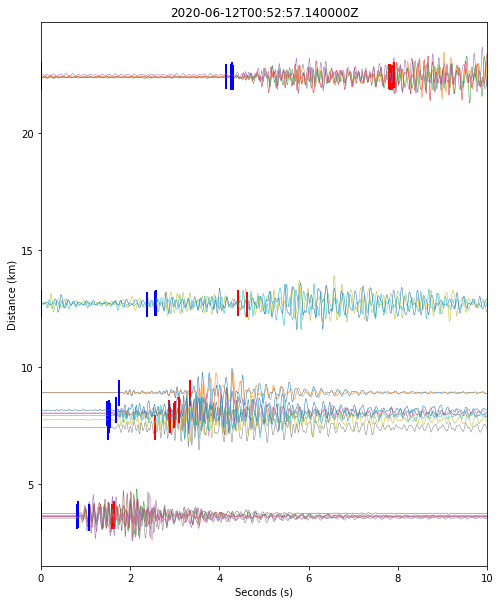

In [3]:
if len(st) == 0:
    print("Error: Nothing to plot!")
#Inititae parameters
min_time = st[0].stats.starttime
max_time = st[0].stats.endtime
for tr in st[1:]:
    if tr.stats.starttime < min_time:
        min_time = tr.stats.starttime
    if tr.stats.endtime > max_time:
        max_time = tr.stats.endtime
sampling_rate = st[0].stats.sampling_rate

plt.figure(figsize = (8,10))
plt.xlim(0,max_time-min_time)

plt.xlabel("Seconds (s)")
plt.ylabel("Distance (km)")
for tr in st:
    tr_ref_time = read_sac_ref_time(tr) 
    tr_o_value = tr.stats.sac.o
    event_time = tr_ref_time + tr_o_value
    try:
        dist = tr.stats.sac.dist
    except:
        evla = tr.stats.sac.evla
        evlo = tr.stats.sac.evlo
        stla = tr.stats.sac.stla
        stlo = tr.stats.sac.stlo
        dist = spherical_dist(evlo,evla,stlo,stla)*111

    starttime = tr.stats.starttime
    x_start = starttime - min_time
    disp_data = tr.data*2/(max(tr.data) - min(tr.data)) #Normalize the waveform and display
    plt.plot(np.arange(0,len(tr.data))/sampling_rate+x_start,disp_data+dist,linewidth = 0.5)
    plt.plot([event_time-min_time,event_time - min_time],[dist-0.5,dist+0.5],color='k',linewidth = 2)
    #plot P phase
    try:
        a = tr.stats.sac.a
        rela_a = tr_ref_time + a - min_time
        plt.plot([rela_a,rela_a],[dist-0.5,dist+0.5],color='b',linewidth = 2)
    except:
        pass
    try:
        t0 = tr.stats.sac.t0
        rela_t0 = tr_ref_time + t0 - min_time
        plt.plot([rela_t0,rela_t0],[dist-0.5,dist+0.5],color='r',linewidth = 2)
    except:
        pass
    if e_mag>-9:
        plt.title(str(tr_ref_time)+f"_M{e_mag}")
    else:
        plt.title(str(tr_ref_time))
    plt.savefig("34362.png",format="png")